In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torchvision.utils as vutils


In [3]:

transform = transforms.Compose([
    transforms.Resize((42, 42)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])])

train_dataset = datasets.CIFAR10(root="./data", train=True,
                                 download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="./data", train=False,
                                download=True, transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32,shuffle=True, pin_memory=True)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

images, labels = next(iter(train_loader))
print("Batch X shape:", images.shape)
print("Batch y shape:", labels.shape)

Batch X shape: torch.Size([32, 3, 42, 42])
Batch y shape: torch.Size([32])


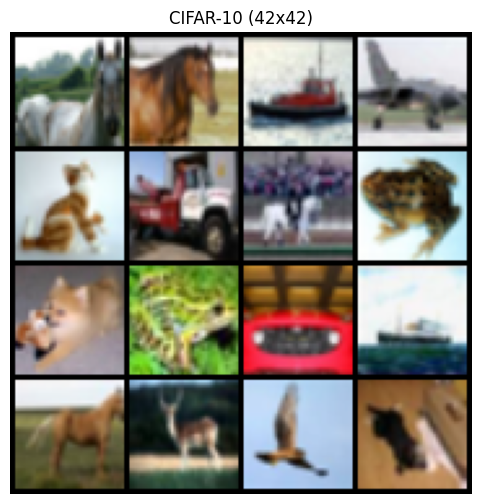

In [5]:
grid = vutils.make_grid(images[:16], nrow=4, normalize=True, scale_each=True)
plt.figure(figsize=(6,6))
plt.axis("off")
plt.title("CIFAR-10 (42x42)")
plt.imshow(grid.permute(1, 2, 0).numpy())
plt.show()

In [6]:
import torch.nn as nn

class Discriminator(nn.Module):
    """
    Discriminador  para imágenes 3x64x64.
    Conv(3x3, padding=1) mantiene tamaño; solo MaxPool(2) reduce.
    Salida: probabilidad en (0,1) vía Sigmoid.
    """

    def __init__(self, img_channels=3, base=64, max_ch=1024, p_drop=0.3):

        super().__init__()
        c1, c2, c3, c4 = base, base*2, base*4, max_ch  # 64, 128, 256, 1024 en numeros de filtros por conv

        def block(in_c, out_c, bn=True):
            layers = [nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1, bias=False)] # Same padding
            if bn:
                layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        self.features = nn.Sequential(
            # 64x64 - (64 , 3x3)  = (N, 64, 64, 64)
            block(img_channels, c1, bn=False),
            block(c1, c1, bn=True),
            nn.Dropout2d(p_drop),
            nn.MaxPool2d(2),  # 64 -> 32

            # 32x32 - (128 , 3x3) = (N, 128, 32, 32)
            block(c1, c2, bn=True),
            nn.Dropout2d(p_drop),
            nn.MaxPool2d(2),  # 32 -> 16

            # 16x16 - (256 , 3x3) = (N, 256, 16, 16)
            block(c2, c3, bn=True),
            nn.Dropout2d(p_drop),
            nn.MaxPool2d(2),  # 16 -> 8

            # 8x8 - (1024 , 3x3)  = ( N, 1024, 8, 8)
            block(c3, c4, bn=True),
            nn.Dropout2d(p_drop))


        self.classifier = nn.Sequential(
            nn.Flatten(), # vector (1024x8x8)
            nn.LazyLinear(1, bias=True)) # Capa automarica que detecta el input

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [7]:
class Generator(nn.Module):
    """
    Generador tipo DCGAN para imágenes 3x64x64.
    Input: vector z (N, latent_dim)
    Output: imagen (N, 3, 64, 64)
    """
    def __init__(self, latent_dim=100, ngf=64, img_channels=3 , img_dim = (64,64)):
        super().__init__()

        self.latent_dim = latent_dim

        self.net = nn.Sequential(
            # Z = (N, latent_dim, 1, 1) a (512, 4x4) = (N, 512, 4, 4)
            nn.ConvTranspose2d(latent_dim, ngf*8, 4, 1, 0, bias=False), # kernel=4 , pad = 0 , stride = 1
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),

            # 4 a 8 - (256, 4x4) = (N, 256, 8, 8)
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False), # kernel=4 , pad = 1 , stride = 2 (duplica tama;o imagen)
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            # 8 a 16 - (128, 4x4) = (N, 128, 16, 16)
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            # 16 a 32 - (64, 4x4) = (N, 64, 32, 32)
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # 32 a 64 - (3, 4x4)= (N, 3, 64, 64)
            nn.ConvTranspose2d(ngf, img_channels, 3, 2, 1, bias=False),
            nn.AdaptiveAvgPool2d(img_dim),
            nn.Tanh())

    def forward(self, z):
        return self.net(z.view(z.size(0), z.size(1), 1, 1))


def weights_init_normal(m):
    name = m.__class__.__name__
    if 'Conv' in name:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    if 'BatchNorm' in name:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)


In [8]:
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

latent_dim = 100
gen = Generator(latent_dim=latent_dim, ngf=64, img_channels=3 , img_dim= (42,42) ).to(device)
disc = Discriminator(img_channels=3, base=64, max_ch=1024, p_drop=0.5).to(device)

gen.apply(weights_init_normal)
disc.apply(weights_init_normal)

criterion = nn.BCEWithLogitsLoss()
optimizerGen = optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizerDisc = optim.Adam(disc.parameters(), lr=2e-4, betas=(0.5, 0.999))

In [9]:
import torchvision.utils as vutils
import os

def train_gan(train_loader, generador, discriminador,
    optimizerG, optimizerD, criterion,
    latent_dim = 100, epochs = 20, sample_every = 1,
    fixed_z = None , smooth = False , smooth_advance = False , monitor_img = 5 , monitor_loss = 2):

    """
    Entrena una GAN : D con Sigmoid + BCELoss; G con pérdida no-saturante.

    Retorna: diccionario con histórico de pérdidas por epoch: {'loss_D': [...], 'loss_G': [...]}
    """

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    generador.to(device)
    discriminador.to(device)

    if smooth == True and smooth_advance == True:
        raise ValueError(f'No se puede tener dos suavizamientos al tiempo')

    # Vector de ruido fijo para ver progreso consistente a través de epochs
    if fixed_z is None:
        os.makedirs("samples", exist_ok=True)
        fixed_z = torch.randn(64, latent_dim, device=device)

        with torch.no_grad():
          fake_imgs_init = generador(fixed_z).detach()

        path = f"samples/epoch_init.png"
        vutils.save_image(fake_imgs_init, path, normalize=True, nrow=8)

        grid = vutils.make_grid(fake_imgs_init, normalize=True, nrow=8)
        grid_cpu = grid.detach().cpu()
        plt.figure(figsize=(6,6))
        plt.axis("off")
        plt.title(f"Fake samples (init)")
        plt.imshow(grid_cpu.permute(1, 2, 0).numpy())
        plt.show()
    else:
        fixed_z = fixed_z.to(device)


    history = {'loss_D': [], 'loss_G': []}

    generador.train()
    discriminador.train()

    for epoch in range(1, epochs + 1):
        running_D, running_G, n_batches = 0.0, 0.0, 0

        for real, _ in train_loader:
            b = real.size(0)
            real = real.to(device, non_blocking=True)
            # Etiquetas: 1 para reales, 0 para falsas


            if smooth:
                real_labels = torch.full((b, 1), 0.9 , device=device)
            elif smooth_advance:
                real_labels = torch.empty(b, 1, device=device).uniform_(0.8, 1.0) # en vez de todos exactamente 0.9, los hacemos variar entre 0.8 y 1.0
            else:
                real_labels = torch.ones(b, 1, device=device)

            fake_labels = torch.zeros(b, 1, device=device)

            # =====================================
            # (1) Update D: max log D(x) + log(1 - D(G(z))) =  O sea verdaderas como verdaderas, falsas como falsas

            # En la practica queremos que su loss sea 0.69 (−log 0.5)
            # Para un G fijo D si logra maximizar (una iteracion), cuando G cambia: D se deberia volver mas ineficiente.
            # Al final el discriminador se vuelve igual que lanzar una moneda 50/50
            # =====================================
            optimizerD.zero_grad(set_to_none=True)

            # Reales: D(x) debe acercarse a 1
            out_real = discriminador(real)           # Probabilidades debido a sigmoid
            loss_D_real = criterion(out_real, real_labels) # −log D(real).

            # Falsas: G(z) -> detach para NO actualizar G en el paso de D
            z = torch.randn(b, latent_dim , device=device)
            fake = generador(z).detach()                      # rompe gradiente hacia G
            out_fake = discriminador(fake)                    # D(G(z)) debe acercarse a 0 para maximizar
            loss_D_fake = criterion(out_fake, fake_labels)    # −log (1 − D(G(z)))

            # Promediamos pérdidas real/fake para estabilidad
            loss_D = 0.5 * (loss_D_real + loss_D_fake)
            loss_D.backward() # Actualizamos solo D
            optimizerD.step()

            # =====================================
            # (2) Update G:  min log(1 - D(G(z)))  ≡  max log D(G(z)) o sea confundir al discriminador

            # Aca lo importante es notar que ambas cosas no pueden maximizarse a la misma vez son contrarias.
            # =====================================
            loss_G_total = 0.0

            for i in range(2):
              optimizerG.zero_grad(set_to_none=True)
              z = torch.randn(b, latent_dim , device=device)
              fake = generador(z)                               # ahora SÍ queremos gradiente hacia G
              out_fake_for_G = discriminador(fake)

              # G quiere que D "piense" que estas falsas son reales (target=1)
              loss_G = criterion(out_fake_for_G, real_labels) # Perdida no saturante

              loss_G.backward() #  retropropaga el gradiente a través de D (porque lo usamos para las probs) pero solo actualiza G
              optimizerG.step()
              loss_G_total += loss_G.item()


            # Acumular métricas
            running_D += loss_D.item()
            running_G += loss_G_total / 2.0
            n_batches += 1

        epoch_loss_D = running_D / max(n_batches, 1)
        epoch_loss_G = running_G / max(n_batches, 1)
        history['loss_D'].append(epoch_loss_D)
        history['loss_G'].append(epoch_loss_G)


        if (sample_every is not None) and ((epoch + 1) % monitor_loss == 0):
            print(f"[Epoch {epoch:03d}/{epochs}]  loss_D={epoch_loss_D:.4f} | loss_G={epoch_loss_G:.4f}")

        if (sample_every is not None) and ((epoch + 1) % monitor_img == 0):

            with torch.no_grad():
                fake_imgs = generador(fixed_z).detach()

            path = f"samples/epoch_{epoch+1:04d}.png"
            vutils.save_image(fake_imgs, path, normalize=True, nrow=8)

            grid = vutils.make_grid(fake_imgs, normalize=True, nrow=8)
            grid_cpu = grid.detach().cpu()
            plt.figure(figsize=(6,6))
            plt.axis("off")
            plt.title(f"Fake samples (epoch {epoch+1})")
            plt.imshow(grid_cpu.permute(1, 2, 0).numpy())
            plt.show()

    return history


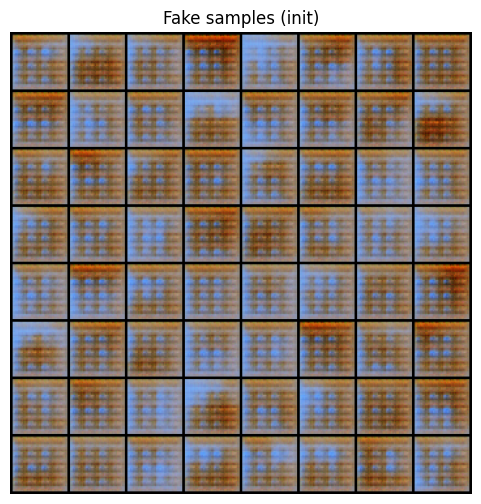

[Epoch 001/80]  loss_D=0.7229 | loss_G=1.0938
[Epoch 003/80]  loss_D=0.7188 | loss_G=0.8404


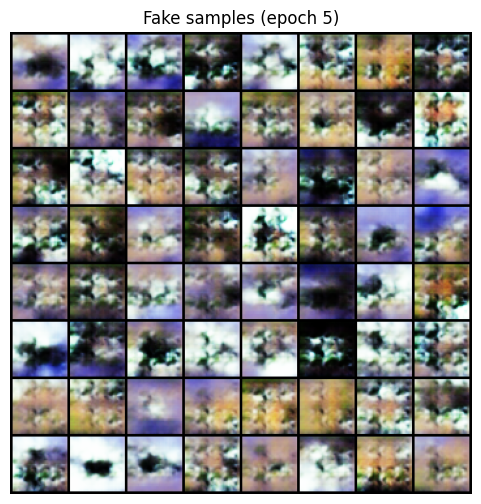

[Epoch 005/80]  loss_D=0.7077 | loss_G=0.8455
[Epoch 007/80]  loss_D=0.7030 | loss_G=0.8438
[Epoch 009/80]  loss_D=0.7017 | loss_G=0.8279


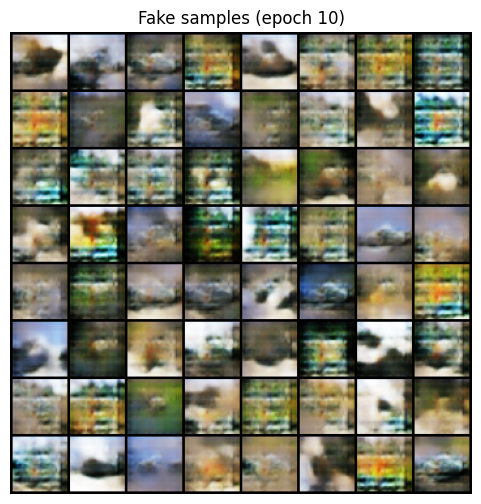

[Epoch 011/80]  loss_D=0.6968 | loss_G=0.8242
[Epoch 013/80]  loss_D=0.6938 | loss_G=0.8287


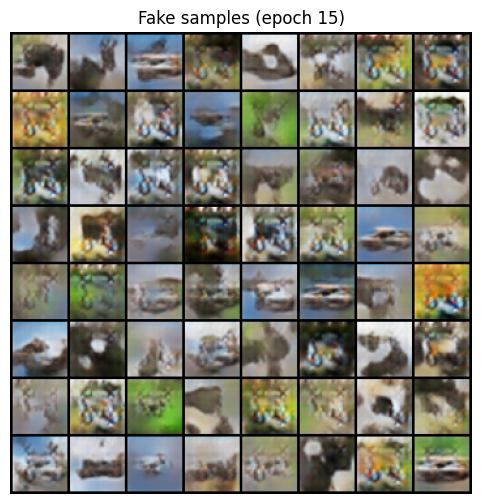

[Epoch 015/80]  loss_D=0.6832 | loss_G=0.8531
[Epoch 017/80]  loss_D=0.6871 | loss_G=0.8456
[Epoch 019/80]  loss_D=0.6850 | loss_G=0.8518


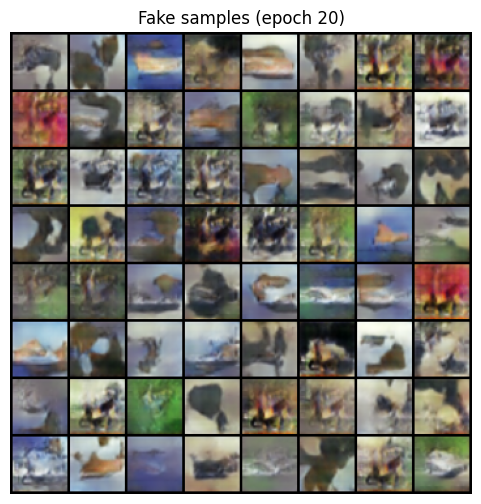

[Epoch 021/80]  loss_D=0.6830 | loss_G=0.8526
[Epoch 023/80]  loss_D=0.6846 | loss_G=0.8432


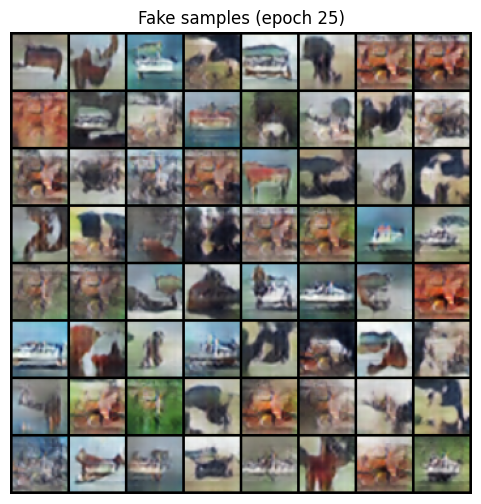

[Epoch 025/80]  loss_D=0.6825 | loss_G=0.8560
[Epoch 027/80]  loss_D=0.6812 | loss_G=0.8514
[Epoch 029/80]  loss_D=0.6827 | loss_G=0.8521


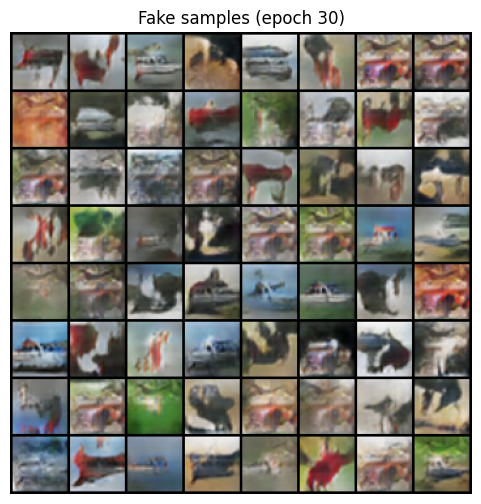

[Epoch 031/80]  loss_D=0.6778 | loss_G=0.8605
[Epoch 033/80]  loss_D=0.6800 | loss_G=0.8586


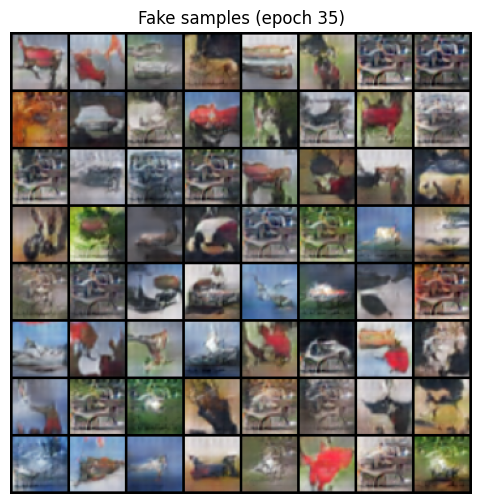

[Epoch 035/80]  loss_D=0.6735 | loss_G=0.8651
[Epoch 037/80]  loss_D=0.6761 | loss_G=0.8602
[Epoch 039/80]  loss_D=0.6809 | loss_G=0.8555


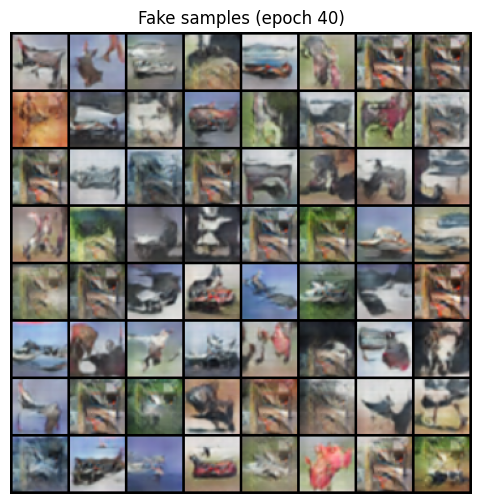

[Epoch 041/80]  loss_D=0.6698 | loss_G=0.8835
[Epoch 043/80]  loss_D=0.6683 | loss_G=0.8927


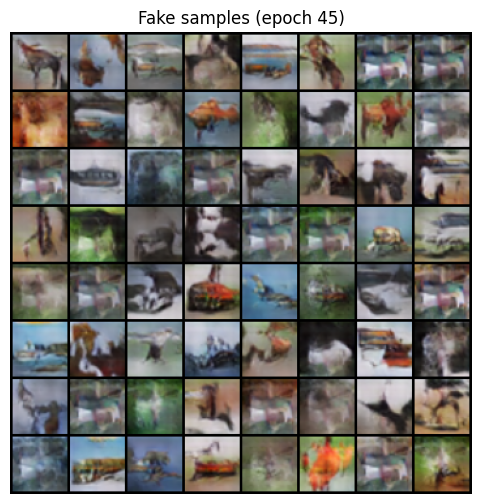

[Epoch 045/80]  loss_D=0.6675 | loss_G=0.8973
[Epoch 047/80]  loss_D=0.6639 | loss_G=0.9061
[Epoch 049/80]  loss_D=0.6603 | loss_G=0.9162


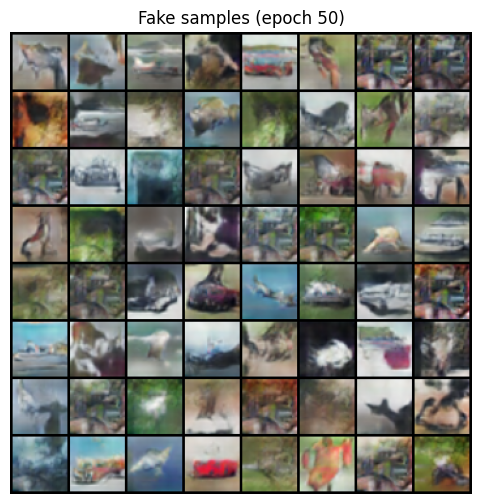

[Epoch 051/80]  loss_D=0.6657 | loss_G=0.9107
[Epoch 053/80]  loss_D=0.6641 | loss_G=0.9045


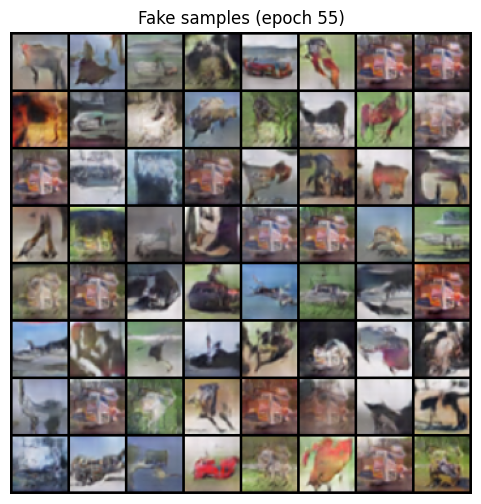

[Epoch 055/80]  loss_D=0.6611 | loss_G=0.9190
[Epoch 057/80]  loss_D=0.6627 | loss_G=0.9076
[Epoch 059/80]  loss_D=0.6518 | loss_G=0.9444


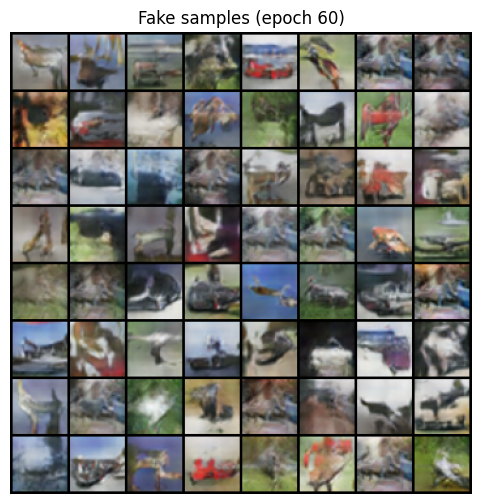

[Epoch 061/80]  loss_D=0.6572 | loss_G=0.9282
[Epoch 063/80]  loss_D=0.6597 | loss_G=0.9231


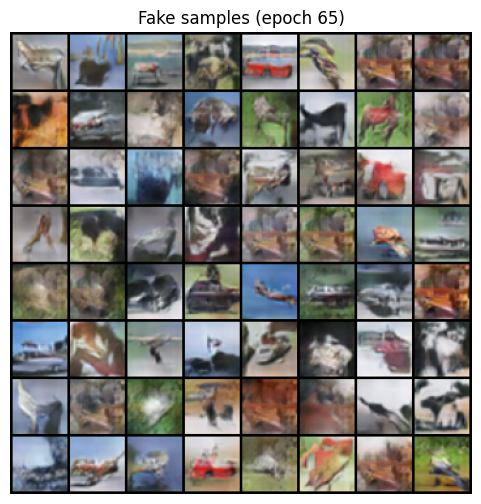

[Epoch 065/80]  loss_D=0.6508 | loss_G=0.9480
[Epoch 067/80]  loss_D=0.6505 | loss_G=0.9344
[Epoch 069/80]  loss_D=0.6506 | loss_G=0.9479


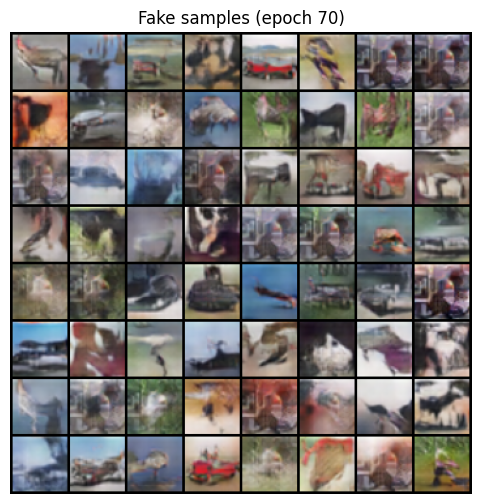

[Epoch 071/80]  loss_D=0.6429 | loss_G=0.9609
[Epoch 073/80]  loss_D=0.6431 | loss_G=0.9654


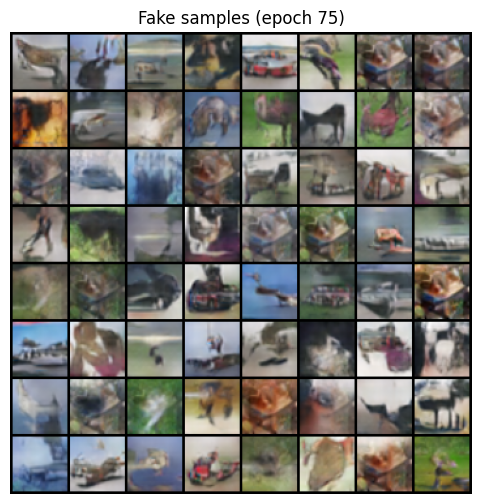

[Epoch 075/80]  loss_D=0.6415 | loss_G=0.9802
[Epoch 077/80]  loss_D=0.6468 | loss_G=0.9716
[Epoch 079/80]  loss_D=0.6395 | loss_G=0.9800


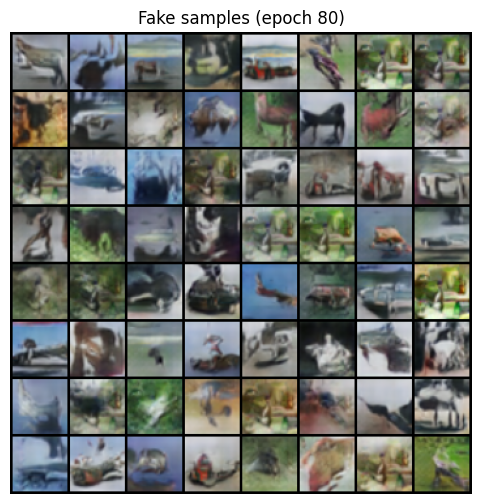

In [26]:
history = train_gan( train_loader=train_loader,
    generador=gen, discriminador=disc, optimizerG=optimizerGen, optimizerD=optimizerDisc,
    criterion=criterion,
    latent_dim=100, epochs=80, sample_every=1 , smooth_advance=True , monitor_img=5 , monitor_loss=2)

In [27]:
torch.save(gen.state_dict(), "Generador_30epochs.pth")
torch.save(disc.state_dict(), "Discriminador_30epochs.pth")

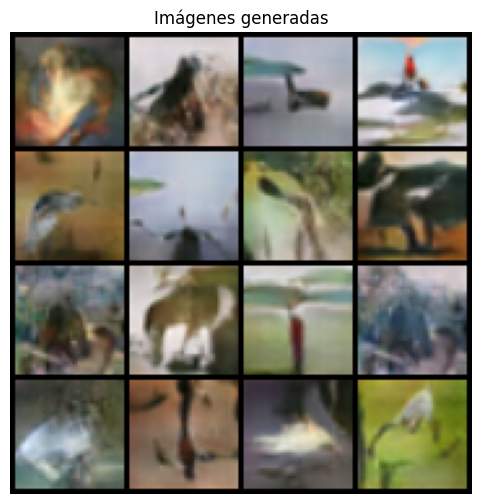

In [35]:
z = torch.randn(16, 100, device=device)

gen.eval()
with torch.no_grad():
  fake_imgs = gen(z).detach().cpu()

grid = vutils.make_grid(fake_imgs, normalize=True, nrow=4)
plt.figure(figsize=(6,6))
plt.axis("off")
plt.title("Imágenes generadas")
plt.imshow(grid.permute(1, 2, 0).numpy())
plt.show()